## TGF-β Signaling Pathway Model

This notebook studies parameters identifiability of the **TGF-β signaling pathway model** proposed in [Geier F, Fengos G, Felizzi F, Iber D. Analyzing and Constraining Signaling Networks](https://link.springer.com/book/10.1007%2F978-1-61779-833-7). Identifiability of this model was analyzed in this article \[\*\] [Parameter identifiability analysis and visualization in large-scale kinetic models of biosystems](https://bmcsystbiol.biomedcentral.com/articles/10.1186/s12918-017-0428-y). We used the equations and datasets provided by the authors of this article in the use-cases of [visid](https://github.com/gabora/visid) software. Our goal is to compare *CICOBase* results with the results of \[\*\]. 

The following ODE system defines the **TGF-β signaling pathway model**

In [1]:
using DiffEqBase, OrdinaryDiffEq, Sundials, CSV, Plots, NLopt, CICOBase, DataFrames

# ODE function
function ode_func(du,u,p,t)
    #parameters
    k1, k2, k4, k5, k6, k7, k8, k9, k10, k11, k12, k13, k14, k15, k16, k17, k18, k19 = p
    k3 = 0.01
    k20 = 9000.
    k21 = 1800.
    
    # concentrations (all concencentrations except I_Smad_mRNA1, I_Smad_mRNA2 are observed in the experiment)
    TGFb, TGFbR, TGFb_TGFbR, TGFb_TGFbR_P, I_Smad_TGFb_TGFbR_P, Smad, Smad_P, CoSmad, Smad_P_Smad_P, Smad_P_CoSmad, 
    Smad_N, Smad_P_Smad_P_N, Smad_P_N, Smad_P_CoSmad_N, CoSmad_N, I_Smad, I_Smad_mRNA1, I_Smad_mRNA2 = u

    # kinetic rates
    r1 = k1*TGFb_TGFbR                                   
    r2 = k2*TGFbR*TGFb                                   
    r3 = k3*TGFb_TGFbR*(1-exp(-((t-k20)/(k21))^10))      
    r4 = k4*TGFb_TGFbR_P                                 
    r5 = k5*TGFb_TGFbR_P*I_Smad                          
    r6 = k6*I_Smad_TGFb_TGFbR_P                          
    r7 = k7*Smad*TGFb_TGFbR_P                            
    r8 = k8*Smad                                         
    r9 = k9*Smad_N                                       
    r10 = k10*2*Smad_P*Smad_P                            
    r11 = k11*Smad_P_Smad_P                              
    r12 = k10*Smad_P*CoSmad                              
    r13 = k11*Smad_P_CoSmad                              
    r14 = k8*CoSmad                                      
    r15 = k9*CoSmad_N                                    
    r16 = k12*k8*Smad_P_Smad_P                           
    r17 = k8*Smad_P                                      
    r18 = k9*Smad_P_N                                    
    r19 = k12*k8*Smad_P_CoSmad                           
    r20 = k13*Smad_P_N                                   
    r21 = k10*2*Smad_P_N*Smad_P_N                        
    r22 = k11*Smad_P_Smad_P_N                            
    r23 = k10*Smad_P_N*CoSmad_N                          
    r24 = k11*Smad_P_CoSmad_N                            
    r25 = k14*Smad_P_CoSmad_N^2/(Smad_P_CoSmad_N^2+k15^2)
    r26 = k16*I_Smad_mRNA1                               
    r27 = k17*I_Smad_mRNA2                               
    r28 = k18*I_Smad_mRNA2                               
    r29 = k19*I_Smad                                     
        
    # rhs
    du[1] = r1-r2                                         
    du[2] = r1-r2                                        
    du[3] = -r1+r2-r3+r4+r6                         
    du[4] = r3-r4-r5                              
    du[5] = r5-r6                          
    du[6] = -r7-r8+r9                                    
    du[7] = r7-r10+r11-r12+r13-r17+r18                 
    du[8] = -r12+r13-r14+r15                           
    du[9] = r10-r11-r16                         
    du[10] = r12-r13-r19                         
    du[11] = r8-r9+r20                                  
    du[12] = r16+r21-r22                       
    du[13] = r17-r18-r20-r21+r22-r23+r24              
    du[14] = r19+r23-r24                       
    du[15] = r14-r15-r23+r24                          
    du[16] = r28-r29-r5+r6                    
    du[17] = r25-r26                            
    du[18] = r26-r27
end;

Initial conditions, estimated parameter values, and time points are taken from [visid repo](https://github.com/gabora/visid/blob/53c5f390f6b0459978c076ace01a4b5f7c165094/case_studies/tgfb/TGFB_amigo.m)

In [2]:
# initial conditions, nominal parameter values and timepoints
# https://github.com/gabora/visid/blob/master/case_studies/tgfb/TGFB_amigo.m
u0 = [
    1., 
    1., 
    -1.3645e-017, 
    -1.3645e-017, 
    -1.0333e-034, 
    40.976, 
    3.5121e-011, 
    34.146, 
    2.3805e-021, 
    -5.2419e-011, 
    19.024,
    1.0252e-018,
    6.218e-011,
    4.1486e-009,
    15.854,
    5.3131e-017,
    6.504e-017,
    3.7963e-017
]
    
p0 = [
    0.00015,
    0.023,
#    0.01, not estimated in fitting
    0.01,
    0.01,
    0.1,
    0.000404,
    0.0026,
    0.0056,
    0.002,
    0.016,
    5.7,
    0.00657,
    0.0017,
    1.,
    0.0008,
    0.001,
    0.0021,
    0.001
#    9000., not estimated in fitting
#    1800.  not estimated in fitting
]

time_points = [
    0.,
    1285.71,
    2571.43,
    3857.14,
    5142.86,
    6428.57,
    7714.29,
    9000.,
    10285.7,
    11571.4,
    12857.1,
    14142.9,
    15428.6,
    16714.3,
    18000.
]

# time interval to solve on
tspan = (0., 18000.);

Next we solve the IVP (Initial Value Problem)

In [3]:
# next we create an IVP 
prob = ODEProblem(ode_func, u0, tspan, p0)

# solver algorithm, tolerances and max iterations
solver_opts = Dict(
    :alg => AutoTsit5(Rosenbrock23()),
    :reltol => 1e-7,
    :abstol => 1e-7
)

# we are interested only in concentrations observed in the experiment, hence "save_idxs = 1:16"
sol = solve(
    prob, 
    solver_opts[:alg], 
    reltol=solver_opts[:reltol],
    abstol=solver_opts[:abstol],
    saveat=time_points,
    save_idxs = 1:16
);

We use pseudo-experimental dataset from [visid repo](https://github.com/gabora/visid/blob/53c5f390f6b0459978c076ace01a4b5f7c165094/case_studies/tgfb/TGFB_amigo.m) and plot one of the variables (TGFb) together with experimental data

In [4]:
dataset = CSV.read("TGFb_data.csv", DataFrame)

# standard deviation (sigma and not sigma^2!)
# provided in inputs.exps.error_data{iexp}
sigmas = CSV.read("TGFb_error.csv", DataFrame);

┌ Warning: To maintain consistency with solution indexing, keyword argument vars will be removed in a future version. Please use keyword argument idxs instead.
│   caller = ip:0x0
└ @ Core :-1


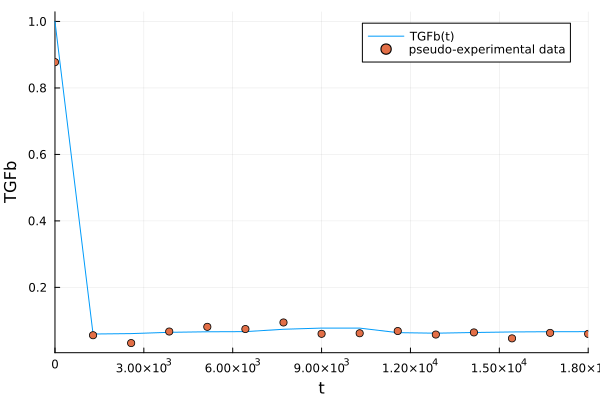

In [5]:
plot(sol, vars=(0,1), xlabel = "t", ylabel = "TGFb", label="TGFb(t)");
scatter!(dataset[!,:time],dataset[!,:TGFb], label = "pseudo-experimental data")

To fit parameters to pseudo-experimental data we use the following likelihood function provided by the authors of \[\*\] in [AMIGO2 package](https://github.com/csynbiosys/AMIGO2R2016b). According to AMIGO2 docs:

*For the homoscedastic case, for which the variance is known or constant, the cost function results
to be similar to the generalized least squares, with weights taken as the inverse of the variance of
the experimental data*

$$ \Lambda = \sum_{i=1}^n \left(\frac{y(t_i) - \tilde y_i}{\sigma_i}\right)^2 $$

Here 
$n$ - number of observations (experimental data time points),
$\tilde y_i$ - experimental data,
$y(t_i)$ - numerical solution,
$\sigma_i $ - standard deviation of heteroscedastic noise

In [6]:
# loss function 
# for 'hetero' case 
# https://github.com/csynbiosys/AMIGO2R2016b/blob/63b131e0274096f9aef6ca42d0332ff113d1828a/Kernel/AMIGO_PEcost.m#L322

function loss_func(sol, data, sigma) # sum by components
    loss = 0.0
    for i in eachindex(sol.u[1]) #1:16
        loss += loss_i(sol[i,:], data[!,i+1], sigma[!,i+1])
    end
    return loss
end

function loss_i(sol, data, sigma) # sum by data points
    loss = 0.0  
    for i in eachindex(sol)
        loss += ((sol[i] - data[i])/sigma[i])^2
    end
    return loss 
end;

Objective function is a wrapper for parameters updates during fitting `obj_func = (params)->loss`

In [7]:
# obj function (params,prob)->loss
function obj_func(params;
                  prob=prob, 
                  solver_opts=solver_opts, 
                  time_points=time_points,
                  loss=(sol)->loss_func(sol,dataset,sigmas)
)
    prob_p = remake(prob,p=params)
    sol_p = solve(prob_p, 
                  solver_opts[:alg], 
                  reltol=solver_opts[:reltol], 
                  abstol=solver_opts[:abstol], 
                  saveat=time_points,
                  save_idxs = 1:16)
    loss(sol_p)
end;

Now we fit parameters to the dataset with *NLopt* package. See [NLopt documentation](https://nlopt.readthedocs.io/en/latest) for details

In [8]:
# fitting algorithm and search bounds

fitter_opts = Dict(
    :alg => :LN_SBPLX
)

# lower, upper bounds and start values formula:
# https://github.com/gabora/visid/blob/master/case_studies/tgfb/TGFB_amigo.m
lb = [1e-6, 0.0001, 1e-6, 0.0001, 1e-6, 1e-6, 1e-5, 1e-5, 1e-6, 1e-5, 0.1, 1e-5, 1e-5, 0.001, 1e-5, 1e-5, 1e-5, 1e-5]
ub = [0.1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 100., 1.0, 1.0, 100., 0.1, 0.1, 0.1, 0.1]

# start values generated with exp.(log.(lb) + rand(length(p0)).*(log.(ub) - log.(lb)))
p_start = [3.52E-05,
           0.00131226,
           0.00151732,
           0.0395871,
           1.63E-05,
           0.000251247,
           0.000112007,
           0.00783227,
           0.0424562,
           0.000142716,
           8.20992,
           0.000270499,
           0.0213893,
           1.41254,
           0.000121978,
           0.00658392,
           0.000205464,
           0.0111338]

opt = CICOBase.NLopt.Opt(fitter_opts[:alg], length(p0))
opt.min_objective = (p,grad) -> obj_func(p)
opt.lower_bounds = lb
opt.upper_bounds = ub
opt.xtol_rel = 1e-3

(loss,p,ret) = CICOBase.NLopt.optimize(opt, p_start)

(266.4304286862838, [0.0002290100323639326, 0.034062308265112966, 0.009190331178398126, 0.009397837818185099, 0.09984707196991427, 0.0003603781799218335, 0.0012436335138352544, 0.0027941738043466367, 0.001485713457196536, 0.011736726315087891, 9.135925727754511, 0.006429496691451377, 0.1503929163818522, 1.3782294060271663, 0.0007144737649710162, 0.0013187312206062762, 2.9047538654247835e-5, 0.0007398218861179926], :XTOL_REACHED)

Let's use *CICOBase* package to determine identifiable parameters and compute confidence intrvals.
We choose identification confidence level $ \alpha = loss + 3.84$, where $loss $ is the minimum likelihood function value obtained during fitting and 3.84 is *Chi-square statistics* with 1 degree of freedom and P-value=0.05.
Please, look up [CICOBase documentation](https://insysbio.github.io/CICOBase.jl/latest/) for details

In [9]:
α = loss + 3.84
scan_bounds = tuple.(lb/10,ub*10)
theta_bounds = tuple.(lb/100.,ub*100)

intervals = Vector{ParamInterval}(undef,length(p))
for i in eachindex(p)
    
    intervals[i] = get_interval(
        p,
        i,
        (p)->obj_func(p),
        :CICO_ONE_PASS,
        loss_crit = α,
        theta_bounds = theta_bounds,
        scan_bounds = scan_bounds[i],
        local_alg = :LN_SBPLX,
        #scale = fill(:log,length(p))
    )
    println(intervals[i]) 
end

left CP counter: 2    Time: 0:00:01 ( 0.63  s/it)
left CP counter: 104    Time: 0:00:02 (24.94 ms/it)
left CP counter: 131    Time: 0:00:02 (21.43 ms/it)
left CP counter: 144    Time: 0:00:02 (20.24 ms/it)
left CP counter: 156    Time: 0:00:03 (20.64 ms/it)
left CP counter: 169    Time: 0:00:03 (19.72 ms/it)
left CP counter: 182    Time: 0:00:03 (18.92 ms/it)
left CP counter: 195    Time: 0:00:03 (18.21 ms/it)
left CP counter: 208    Time: 0:00:03 (17.58 ms/it)
left CP counter: 221    Time: 0:00:03 (17.03 ms/it)
left CP counter: 235    Time: 0:00:03 (16.49 ms/it)
left CP counter: 249    Time: 0:00:03 (16.00 ms/it)
left CP counter: 262    Time: 0:00:04 (15.62 ms/it)
left CP counter: 275    Time: 0:00:04 (15.29 ms/it)
left CP counter: 288    Time: 0:00:04 (14.97 ms/it)
left CP counter: 301    Time: 0:00:04 (14.69 ms/it)
left CP counter: 314    Time: 0:00:04 (14.43 ms/it)
left CP counter: 325    Time: 0:00:04 (14.28 ms/it)
left CP counter: 337    Time: 0:00:04 (14.09 ms/it)
left CP counte

ParamInterval(ParamIntervalInput([0.0002290100323639326, 0.034062308265112966, 0.009190331178398126, 0.009397837818185099, 0.09984707196991427, 0.0003603781799218335, 0.0012436335138352544, 0.0027941738043466367, 0.001485713457196536, 0.011736726315087891, 9.135925727754511, 0.006429496691451377, 0.1503929163818522, 1.3782294060271663, 0.0007144737649710162, 0.0013187312206062762, 2.9047538654247835e-5, 0.0007398218861179926], 1, var"#18#19"(), :CICO_ONE_PASS, Dict{Symbol, Any}(:theta_bounds => [(1.0e-8, 10.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (0.001, 10000.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-5, 10000.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0)], :loss_crit => 270.27042868628376, :scan_bounds => (1.0e-7, 

left CP counter: 13    Time: 0:00:00 ( 8.08 ms/it)
left CP counter: 25    Time: 0:00:00 ( 8.48 ms/it)
left CP counter: 37    Time: 0:00:00 ( 8.68 ms/it)
left CP counter: 49    Time: 0:00:00 ( 8.73 ms/it)
left CP counter: 61    Time: 0:00:00 ( 8.75 ms/it)
left CP counter: 74    Time: 0:00:00 ( 8.70 ms/it)
left CP counter: 87    Time: 0:00:00 ( 8.67 ms/it)
left CP counter: 99    Time: 0:00:00 ( 8.71 ms/it)
left CP counter: 111    Time: 0:00:00 ( 8.95 ms/it)
left CP counter: 124    Time: 0:00:01 ( 8.89 ms/it)
left CP counter: 136    Time: 0:00:01 ( 8.97 ms/it)
left CP counter: 148    Time: 0:00:01 ( 8.98 ms/it)
left CP counter: 159    Time: 0:00:01 ( 9.04 ms/it)
left CP counter: 170    Time: 0:00:01 ( 9.09 ms/it)
left CP counter: 181    Time: 0:00:01 ( 9.17 ms/it)
left CP counter: 191    Time: 0:00:01 ( 9.24 ms/it)
left CP counter: 203    Time: 0:00:01 ( 9.27 ms/it)
left CP counter: 215    Time: 0:00:01 ( 9.27 ms/it)
left CP counter: 227    Time: 0:00:02 ( 9.24 ms/it)
left CP counter: 239

ParamInterval(ParamIntervalInput([0.0002290100323639326, 0.034062308265112966, 0.009190331178398126, 0.009397837818185099, 0.09984707196991427, 0.0003603781799218335, 0.0012436335138352544, 0.0027941738043466367, 0.001485713457196536, 0.011736726315087891, 9.135925727754511, 0.006429496691451377, 0.1503929163818522, 1.3782294060271663, 0.0007144737649710162, 0.0013187312206062762, 2.9047538654247835e-5, 0.0007398218861179926], 2, var"#18#19"(), :CICO_ONE_PASS, Dict{Symbol, Any}(:theta_bounds => [(1.0e-8, 10.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (0.001, 10000.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-5, 10000.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0)], :loss_crit => 270.27042868628376, :scan_bounds => (1.0e-5, 

left CP counter: 11    Time: 0:00:00 ( 9.27 ms/it)
left CP counter: 24    Time: 0:00:00 ( 8.63 ms/it)
left CP counter: 37    Time: 0:00:00 ( 8.57 ms/it)
left CP counter: 49    Time: 0:00:00 ( 8.55 ms/it)
left CP counter: 61    Time: 0:00:00 ( 8.90 ms/it)
left CP counter: 73    Time: 0:00:00 ( 8.95 ms/it)
left CP counter: 86    Time: 0:00:00 ( 8.88 ms/it)
left CP counter: 98    Time: 0:00:00 ( 8.90 ms/it)
left CP counter: 112    Time: 0:00:00 ( 8.78 ms/it)
left CP counter: 125    Time: 0:00:01 ( 8.78 ms/it)
left CP counter: 137    Time: 0:00:01 ( 8.93 ms/it)
left CP counter: 147    Time: 0:00:01 ( 9.03 ms/it)
left CP counter: 157    Time: 0:00:01 ( 9.19 ms/it)
left CP counter: 167    Time: 0:00:01 ( 9.30 ms/it)
left CP counter: 177    Time: 0:00:01 ( 9.43 ms/it)
left CP counter: 188    Time: 0:00:01 ( 9.48 ms/it)
left CP counter: 199    Time: 0:00:01 ( 9.49 ms/it)
left CP counter: 210    Time: 0:00:01 ( 9.52 ms/it)
left CP counter: 220    Time: 0:00:02 ( 9.57 ms/it)
left CP counter: 231

ParamInterval(ParamIntervalInput([0.0002290100323639326, 0.034062308265112966, 0.009190331178398126, 0.009397837818185099, 0.09984707196991427, 0.0003603781799218335, 0.0012436335138352544, 0.0027941738043466367, 0.001485713457196536, 0.011736726315087891, 9.135925727754511, 0.006429496691451377, 0.1503929163818522, 1.3782294060271663, 0.0007144737649710162, 0.0013187312206062762, 2.9047538654247835e-5, 0.0007398218861179926], 3, var"#18#19"(), :CICO_ONE_PASS, Dict{Symbol, Any}(:theta_bounds => [(1.0e-8, 10.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (0.001, 10000.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-5, 10000.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0)], :loss_crit => 270.27042868628376, :scan_bounds => (1.0e-7, 

left CP counter: 13    Time: 0:00:00 ( 8.08 ms/it)
left CP counter: 26    Time: 0:00:00 ( 8.08 ms/it)
left CP counter: 39    Time: 0:00:00 ( 8.10 ms/it)
left CP counter: 51    Time: 0:00:00 ( 8.49 ms/it)
left CP counter: 62    Time: 0:00:00 ( 8.74 ms/it)
left CP counter: 74    Time: 0:00:00 ( 8.70 ms/it)
left CP counter: 87    Time: 0:00:00 ( 8.64 ms/it)
left CP counter: 100    Time: 0:00:00 ( 8.61 ms/it)
left CP counter: 113    Time: 0:00:00 ( 8.58 ms/it)
left CP counter: 125    Time: 0:00:01 ( 8.64 ms/it)
left CP counter: 138    Time: 0:00:01 ( 8.60 ms/it)
left CP counter: 151    Time: 0:00:01 ( 8.58 ms/it)
left CP counter: 164    Time: 0:00:01 ( 8.55 ms/it)
left CP counter: 177    Time: 0:00:01 ( 8.56 ms/it)
left CP counter: 191    Time: 0:00:01 ( 8.49 ms/it)
left CP counter: 205    Time: 0:00:01 ( 8.46 ms/it)
left CP counter: 217    Time: 0:00:01 ( 8.49 ms/it)
left CP counter: 230    Time: 0:00:01 ( 8.46 ms/it)
left CP counter: 243    Time: 0:00:02 ( 8.47 ms/it)
left CP counter: 25

ParamInterval(ParamIntervalInput([0.0002290100323639326, 0.034062308265112966, 0.009190331178398126, 0.009397837818185099, 0.09984707196991427, 0.0003603781799218335, 0.0012436335138352544, 0.0027941738043466367, 0.001485713457196536, 0.011736726315087891, 9.135925727754511, 0.006429496691451377, 0.1503929163818522, 1.3782294060271663, 0.0007144737649710162, 0.0013187312206062762, 2.9047538654247835e-5, 0.0007398218861179926], 4, var"#18#19"(), :CICO_ONE_PASS, Dict{Symbol, Any}(:theta_bounds => [(1.0e-8, 10.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (0.001, 10000.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-5, 10000.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0)], :loss_crit => 270.27042868628376, :scan_bounds => (1.0e-5, 

left CP counter: 11    Time: 0:00:00 ( 9.27 ms/it)
left CP counter: 25    Time: 0:00:00 ( 8.32 ms/it)
left CP counter: 39    Time: 0:00:00 ( 8.33 ms/it)
left CP counter: 52    Time: 0:00:00 ( 8.37 ms/it)
left CP counter: 65    Time: 0:00:00 ( 8.37 ms/it)
left CP counter: 78    Time: 0:00:00 ( 8.31 ms/it)
left CP counter: 91    Time: 0:00:00 ( 8.29 ms/it)
left CP counter: 104    Time: 0:00:00 ( 8.31 ms/it)
left CP counter: 117    Time: 0:00:00 ( 8.29 ms/it)
left CP counter: 130    Time: 0:00:01 ( 8.33 ms/it)
left CP counter: 143    Time: 0:00:01 ( 8.30 ms/it)
left CP counter: 156    Time: 0:00:01 ( 8.36 ms/it)
left CP counter: 168    Time: 0:00:01 ( 8.39 ms/it)
left CP counter: 182    Time: 0:00:01 ( 8.35 ms/it)
left CP counter: 195    Time: 0:00:01 ( 8.33 ms/it)
left CP counter: 208    Time: 0:00:01 ( 8.35 ms/it)
left CP counter: 221    Time: 0:00:01 ( 8.34 ms/it)
left CP counter: 234    Time: 0:00:01 ( 8.36 ms/it)
left CP counter: 247    Time: 0:00:02 ( 8.36 ms/it)
left CP counter: 26

ParamInterval(ParamIntervalInput([0.0002290100323639326, 0.034062308265112966, 0.009190331178398126, 0.009397837818185099, 0.09984707196991427, 0.0003603781799218335, 0.0012436335138352544, 0.0027941738043466367, 0.001485713457196536, 0.011736726315087891, 9.135925727754511, 0.006429496691451377, 0.1503929163818522, 1.3782294060271663, 0.0007144737649710162, 0.0013187312206062762, 2.9047538654247835e-5, 0.0007398218861179926], 5, var"#18#19"(), :CICO_ONE_PASS, Dict{Symbol, Any}(:theta_bounds => [(1.0e-8, 10.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (0.001, 10000.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-5, 10000.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0)], :loss_crit => 270.27042868628376, :scan_bounds => (1.0e-7, 

left CP counter: 13    Time: 0:00:00 ( 8.08 ms/it)
left CP counter: 26    Time: 0:00:00 ( 8.62 ms/it)
left CP counter: 38    Time: 0:00:00 ( 8.68 ms/it)
left CP counter: 51    Time: 0:00:00 ( 8.59 ms/it)
left CP counter: 63    Time: 0:00:00 ( 8.98 ms/it)
left CP counter: 76    Time: 0:00:00 ( 8.87 ms/it)
left CP counter: 89    Time: 0:00:00 ( 8.82 ms/it)
left CP counter: 102    Time: 0:00:00 ( 8.74 ms/it)
left CP counter: 115    Time: 0:00:00 ( 8.67 ms/it)
left CP counter: 128    Time: 0:00:01 ( 8.63 ms/it)
left CP counter: 142    Time: 0:00:01 ( 8.53 ms/it)
left CP counter: 156    Time: 0:00:01 ( 8.52 ms/it)
left CP counter: 170    Time: 0:00:01 ( 8.50 ms/it)
left CP counter: 182    Time: 0:00:01 ( 8.51 ms/it)
left CP counter: 194    Time: 0:00:01 ( 8.54 ms/it)
left CP counter: 207    Time: 0:00:01 ( 8.54 ms/it)
left CP counter: 220    Time: 0:00:01 ( 8.52 ms/it)
left CP counter: 233    Time: 0:00:01 ( 8.55 ms/it)
left CP counter: 246    Time: 0:00:02 ( 8.54 ms/it)
left CP counter: 25

ParamInterval(ParamIntervalInput([0.0002290100323639326, 0.034062308265112966, 0.009190331178398126, 0.009397837818185099, 0.09984707196991427, 0.0003603781799218335, 0.0012436335138352544, 0.0027941738043466367, 0.001485713457196536, 0.011736726315087891, 9.135925727754511, 0.006429496691451377, 0.1503929163818522, 1.3782294060271663, 0.0007144737649710162, 0.0013187312206062762, 2.9047538654247835e-5, 0.0007398218861179926], 6, var"#18#19"(), :CICO_ONE_PASS, Dict{Symbol, Any}(:theta_bounds => [(1.0e-8, 10.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (0.001, 10000.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-5, 10000.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0)], :loss_crit => 270.27042868628376, :scan_bounds => (1.0e-7, 

left CP counter: 13    Time: 0:00:00 ( 7.85 ms/it)
left CP counter: 26    Time: 0:00:00 ( 8.00 ms/it)
left CP counter: 39    Time: 0:00:00 ( 8.13 ms/it)
left CP counter: 52    Time: 0:00:00 ( 8.23 ms/it)
left CP counter: 63    Time: 0:00:00 ( 8.59 ms/it)
left CP counter: 77    Time: 0:00:00 ( 8.40 ms/it)
left CP counter: 91    Time: 0:00:00 ( 8.35 ms/it)
left CP counter: 104    Time: 0:00:00 ( 8.45 ms/it)
left CP counter: 117    Time: 0:00:00 ( 8.42 ms/it)
left CP counter: 129    Time: 0:00:01 ( 8.49 ms/it)
left CP counter: 142    Time: 0:00:01 ( 8.47 ms/it)
left CP counter: 155    Time: 0:00:01 ( 8.44 ms/it)
left CP counter: 168    Time: 0:00:01 ( 8.42 ms/it)
left CP counter: 181    Time: 0:00:01 ( 8.40 ms/it)
left CP counter: 194    Time: 0:00:01 ( 8.37 ms/it)
left CP counter: 207    Time: 0:00:01 ( 8.36 ms/it)
left CP counter: 220    Time: 0:00:01 ( 8.41 ms/it)
left CP counter: 233    Time: 0:00:01 ( 8.39 ms/it)
left CP counter: 246    Time: 0:00:02 ( 8.38 ms/it)
left CP counter: 25

ParamInterval(ParamIntervalInput([0.0002290100323639326, 0.034062308265112966, 0.009190331178398126, 0.009397837818185099, 0.09984707196991427, 0.0003603781799218335, 0.0012436335138352544, 0.0027941738043466367, 0.001485713457196536, 0.011736726315087891, 9.135925727754511, 0.006429496691451377, 0.1503929163818522, 1.3782294060271663, 0.0007144737649710162, 0.0013187312206062762, 2.9047538654247835e-5, 0.0007398218861179926], 7, var"#18#19"(), :CICO_ONE_PASS, Dict{Symbol, Any}(:theta_bounds => [(1.0e-8, 10.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (0.001, 10000.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-5, 10000.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0)], :loss_crit => 270.27042868628376, :scan_bounds => (1.000000

left CP counter: 13    Time: 0:00:00 ( 8.23 ms/it)
left CP counter: 26    Time: 0:00:00 ( 8.31 ms/it)
left CP counter: 38    Time: 0:00:00 ( 8.47 ms/it)
left CP counter: 51    Time: 0:00:00 ( 8.47 ms/it)
left CP counter: 62    Time: 0:00:00 ( 8.82 ms/it)
left CP counter: 73    Time: 0:00:00 ( 8.88 ms/it)
left CP counter: 86    Time: 0:00:00 ( 8.84 ms/it)
left CP counter: 98    Time: 0:00:00 ( 8.85 ms/it)
left CP counter: 110    Time: 0:00:00 ( 8.84 ms/it)
left CP counter: 123    Time: 0:00:01 ( 8.78 ms/it)
left CP counter: 136    Time: 0:00:01 ( 8.76 ms/it)
left CP counter: 148    Time: 0:00:01 ( 8.76 ms/it)
left CP counter: 162    Time: 0:00:01 ( 8.70 ms/it)
left CP counter: 174    Time: 0:00:01 ( 8.70 ms/it)
left CP counter: 187    Time: 0:00:01 ( 8.70 ms/it)
left CP counter: 200    Time: 0:00:01 ( 8.67 ms/it)
left CP counter: 213    Time: 0:00:01 ( 8.67 ms/it)
left CP counter: 225    Time: 0:00:01 ( 8.69 ms/it)
left CP counter: 238    Time: 0:00:02 ( 8.66 ms/it)
left CP counter: 251

ParamInterval(ParamIntervalInput([0.0002290100323639326, 0.034062308265112966, 0.009190331178398126, 0.009397837818185099, 0.09984707196991427, 0.0003603781799218335, 0.0012436335138352544, 0.0027941738043466367, 0.001485713457196536, 0.011736726315087891, 9.135925727754511, 0.006429496691451377, 0.1503929163818522, 1.3782294060271663, 0.0007144737649710162, 0.0013187312206062762, 2.9047538654247835e-5, 0.0007398218861179926], 8, var"#18#19"(), :CICO_ONE_PASS, Dict{Symbol, Any}(:theta_bounds => [(1.0e-8, 10.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (0.001, 10000.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-5, 10000.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0)], :loss_crit => 270.27042868628376, :scan_bounds => (1.000000

left CP counter: 13    Time: 0:00:00 ( 7.85 ms/it)
left CP counter: 28    Time: 0:00:00 ( 7.54 ms/it)
left CP counter: 41    Time: 0:00:00 ( 8.07 ms/it)
left CP counter: 54    Time: 0:00:00 ( 8.07 ms/it)
left CP counter: 67    Time: 0:00:00 ( 8.27 ms/it)
left CP counter: 80    Time: 0:00:00 ( 8.29 ms/it)
left CP counter: 93    Time: 0:00:00 ( 8.26 ms/it)
left CP counter: 106    Time: 0:00:00 ( 8.26 ms/it)
left CP counter: 119    Time: 0:00:00 ( 8.26 ms/it)
left CP counter: 132    Time: 0:00:01 ( 8.24 ms/it)
left CP counter: 145    Time: 0:00:01 ( 8.24 ms/it)
left CP counter: 158    Time: 0:00:01 ( 8.22 ms/it)
left CP counter: 171    Time: 0:00:01 ( 8.22 ms/it)
left CP counter: 185    Time: 0:00:01 ( 8.19 ms/it)
left CP counter: 198    Time: 0:00:01 ( 8.20 ms/it)
left CP counter: 211    Time: 0:00:01 ( 8.18 ms/it)
left CP counter: 225    Time: 0:00:01 ( 8.16 ms/it)
left CP counter: 237    Time: 0:00:01 ( 8.19 ms/it)
left CP counter: 251    Time: 0:00:02 ( 8.16 ms/it)
left CP counter: 26

ParamInterval(ParamIntervalInput([0.0002290100323639326, 0.034062308265112966, 0.009190331178398126, 0.009397837818185099, 0.09984707196991427, 0.0003603781799218335, 0.0012436335138352544, 0.0027941738043466367, 0.001485713457196536, 0.011736726315087891, 9.135925727754511, 0.006429496691451377, 0.1503929163818522, 1.3782294060271663, 0.0007144737649710162, 0.0013187312206062762, 2.9047538654247835e-5, 0.0007398218861179926], 9, var"#18#19"(), :CICO_ONE_PASS, Dict{Symbol, Any}(:theta_bounds => [(1.0e-8, 10.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (0.001, 10000.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-5, 10000.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0)], :loss_crit => 270.27042868628376, :scan_bounds => (1.0e-7, 

left CP counter: 12    Time: 0:00:00 ( 8.33 ms/it)
left CP counter: 26    Time: 0:00:00 ( 7.88 ms/it)
left CP counter: 40    Time: 0:00:00 ( 7.95 ms/it)
left CP counter: 53    Time: 0:00:00 ( 8.15 ms/it)
left CP counter: 65    Time: 0:00:00 ( 8.43 ms/it)
left CP counter: 77    Time: 0:00:00 ( 8.55 ms/it)
left CP counter: 89    Time: 0:00:00 ( 8.56 ms/it)
left CP counter: 102    Time: 0:00:00 ( 8.50 ms/it)
left CP counter: 115    Time: 0:00:00 ( 8.45 ms/it)
left CP counter: 128    Time: 0:00:01 ( 8.45 ms/it)
left CP counter: 142    Time: 0:00:01 ( 8.36 ms/it)
left CP counter: 156    Time: 0:00:01 ( 8.31 ms/it)
left CP counter: 169    Time: 0:00:01 ( 8.36 ms/it)
left CP counter: 183    Time: 0:00:01 ( 8.32 ms/it)
left CP counter: 196    Time: 0:00:01 ( 8.34 ms/it)
left CP counter: 209    Time: 0:00:01 ( 8.34 ms/it)
left CP counter: 221    Time: 0:00:01 ( 8.37 ms/it)
left CP counter: 234    Time: 0:00:01 ( 8.37 ms/it)
left CP counter: 247    Time: 0:00:02 ( 8.37 ms/it)
left CP counter: 26

ParamInterval(ParamIntervalInput([0.0002290100323639326, 0.034062308265112966, 0.009190331178398126, 0.009397837818185099, 0.09984707196991427, 0.0003603781799218335, 0.0012436335138352544, 0.0027941738043466367, 0.001485713457196536, 0.011736726315087891, 9.135925727754511, 0.006429496691451377, 0.1503929163818522, 1.3782294060271663, 0.0007144737649710162, 0.0013187312206062762, 2.9047538654247835e-5, 0.0007398218861179926], 10, var"#18#19"(), :CICO_ONE_PASS, Dict{Symbol, Any}(:theta_bounds => [(1.0e-8, 10.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (0.001, 10000.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-5, 10000.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0)], :loss_crit => 270.27042868628376, :scan_bounds => (1.00000

left CP counter: 13    Time: 0:00:00 ( 8.15 ms/it)
left CP counter: 26    Time: 0:00:00 ( 8.31 ms/it)
left CP counter: 39    Time: 0:00:00 ( 8.36 ms/it)
left CP counter: 52    Time: 0:00:00 ( 8.31 ms/it)
left CP counter: 65    Time: 0:00:00 ( 8.69 ms/it)
left CP counter: 75    Time: 0:00:00 ( 9.19 ms/it)
left CP counter: 83    Time: 0:00:00 ( 9.58 ms/it)
left CP counter: 96    Time: 0:00:00 ( 9.34 ms/it)
left CP counter: 109    Time: 0:00:01 ( 9.28 ms/it)
left CP counter: 121    Time: 0:00:01 ( 9.28 ms/it)
left CP counter: 133    Time: 0:00:01 ( 9.26 ms/it)
left CP counter: 145    Time: 0:00:01 ( 9.29 ms/it)
left CP counter: 157    Time: 0:00:01 ( 9.25 ms/it)
left CP counter: 169    Time: 0:00:01 ( 9.26 ms/it)
left CP counter: 181    Time: 0:00:01 ( 9.22 ms/it)
left CP counter: 194    Time: 0:00:01 ( 9.16 ms/it)
left CP counter: 207    Time: 0:00:01 ( 9.13 ms/it)
left CP counter: 220    Time: 0:00:01 ( 9.08 ms/it)
left CP counter: 232    Time: 0:00:02 ( 9.09 ms/it)
left CP counter: 244

ParamInterval(ParamIntervalInput([0.0002290100323639326, 0.034062308265112966, 0.009190331178398126, 0.009397837818185099, 0.09984707196991427, 0.0003603781799218335, 0.0012436335138352544, 0.0027941738043466367, 0.001485713457196536, 0.011736726315087891, 9.135925727754511, 0.006429496691451377, 0.1503929163818522, 1.3782294060271663, 0.0007144737649710162, 0.0013187312206062762, 2.9047538654247835e-5, 0.0007398218861179926], 11, var"#18#19"(), :CICO_ONE_PASS, Dict{Symbol, Any}(:theta_bounds => [(1.0e-8, 10.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (0.001, 10000.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-5, 10000.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0)], :loss_crit => 270.27042868628376, :scan_bounds => (0.01, 1

left CP counter: 11    Time: 0:00:00 ( 9.55 ms/it)
left CP counter: 25    Time: 0:00:00 ( 8.60 ms/it)
left CP counter: 38    Time: 0:00:00 ( 8.66 ms/it)
left CP counter: 50    Time: 0:00:00 ( 8.62 ms/it)
left CP counter: 62    Time: 0:00:00 ( 8.94 ms/it)
left CP counter: 75    Time: 0:00:00 ( 8.87 ms/it)
left CP counter: 88    Time: 0:00:00 ( 8.76 ms/it)
left CP counter: 101    Time: 0:00:00 ( 8.68 ms/it)
left CP counter: 114    Time: 0:00:00 ( 8.64 ms/it)
left CP counter: 127    Time: 0:00:01 ( 8.60 ms/it)
left CP counter: 141    Time: 0:00:01 ( 8.50 ms/it)
left CP counter: 155    Time: 0:00:01 ( 8.49 ms/it)
left CP counter: 168    Time: 0:00:01 ( 8.49 ms/it)
left CP counter: 179    Time: 0:00:01 ( 8.64 ms/it)
left CP counter: 189    Time: 0:00:01 ( 8.76 ms/it)
left CP counter: 202    Time: 0:00:01 ( 8.79 ms/it)
left CP counter: 214    Time: 0:00:01 ( 8.81 ms/it)
left CP counter: 226    Time: 0:00:01 ( 8.82 ms/it)
left CP counter: 239    Time: 0:00:02 ( 8.79 ms/it)
left CP counter: 25

ParamInterval(ParamIntervalInput([0.0002290100323639326, 0.034062308265112966, 0.009190331178398126, 0.009397837818185099, 0.09984707196991427, 0.0003603781799218335, 0.0012436335138352544, 0.0027941738043466367, 0.001485713457196536, 0.011736726315087891, 9.135925727754511, 0.006429496691451377, 0.1503929163818522, 1.3782294060271663, 0.0007144737649710162, 0.0013187312206062762, 2.9047538654247835e-5, 0.0007398218861179926], 12, var"#18#19"(), :CICO_ONE_PASS, Dict{Symbol, Any}(:theta_bounds => [(1.0e-8, 10.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (0.001, 10000.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-5, 10000.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0)], :loss_crit => 270.27042868628376, :scan_bounds => (1.00000

left CP counter: 42    Time: 0:00:00 ( 2.40 ms/it)
left CP counter: 82    Time: 0:00:00 ( 2.59 ms/it)
left CP counter: 119    Time: 0:00:00 ( 2.73 ms/it)
left CP counter: 154    Time: 0:00:00 ( 2.79 ms/it)
left CP counter: 194    Time: 0:00:00 ( 2.76 ms/it)
left CP counter: 234    Time: 0:00:00 ( 2.79 ms/it)
left CP counter: 269    Time: 0:00:00 ( 2.82 ms/it)
left CP counter: 306    Time: 0:00:00 ( 2.82 ms/it)
left CP counter: 346    Time: 0:00:00 ( 2.80 ms/it)
left CP counter: 389    Time: 0:00:01 ( 2.76 ms/it)
left CP counter: 431    Time: 0:00:01 ( 2.73 ms/it)
left CP counter: 473    Time: 0:00:01 ( 2.71 ms/it)
left CP counter: 514    Time: 0:00:01 ( 2.72 ms/it)
left CP counter: 550    Time: 0:00:01 ( 2.77 ms/it)
left CP counter: 581    Time: 0:00:01 ( 2.80 ms/it)
left CP counter: 620    Time: 0:00:01 ( 2.80 ms/it)
left CP counter: 658    Time: 0:00:01 ( 2.79 ms/it)
left CP counter: 697    Time: 0:00:01 ( 2.79 ms/it)
left CP counter: 710    Time: 0:00:01 ( 2.79 ms/it)
right CP count

ParamInterval(ParamIntervalInput([0.0002290100323639326, 0.034062308265112966, 0.009190331178398126, 0.009397837818185099, 0.09984707196991427, 0.0003603781799218335, 0.0012436335138352544, 0.0027941738043466367, 0.001485713457196536, 0.011736726315087891, 9.135925727754511, 0.006429496691451377, 0.1503929163818522, 1.3782294060271663, 0.0007144737649710162, 0.0013187312206062762, 2.9047538654247835e-5, 0.0007398218861179926], 13, var"#18#19"(), :CICO_ONE_PASS, Dict{Symbol, Any}(:theta_bounds => [(1.0e-8, 10.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (0.001, 10000.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-5, 10000.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0)], :loss_crit => 270.27042868628376, :scan_bounds => (1.00000

left CP counter: 36    Time: 0:00:00 ( 2.81 ms/it)
left CP counter: 73    Time: 0:00:00 ( 2.78 ms/it)
left CP counter: 109    Time: 0:00:00 ( 2.85 ms/it)
left CP counter: 144    Time: 0:00:00 ( 2.92 ms/it)
left CP counter: 177    Time: 0:00:00 ( 3.01 ms/it)
left CP counter: 208    Time: 0:00:00 ( 3.21 ms/it)
left CP counter: 238    Time: 0:00:00 ( 3.26 ms/it)
left CP counter: 282    Time: 0:00:00 ( 3.12 ms/it)
left CP counter: 325    Time: 0:00:00 ( 3.03 ms/it)
left CP counter: 367    Time: 0:00:01 ( 2.99 ms/it)
left CP counter: 405    Time: 0:00:01 ( 3.01 ms/it)
left CP counter: 438    Time: 0:00:01 ( 3.05 ms/it)
left CP counter: 467    Time: 0:00:01 ( 3.12 ms/it)
left CP counter: 498    Time: 0:00:01 ( 3.13 ms/it)
left CP counter: 527    Time: 0:00:01 ( 3.24 ms/it)
left CP counter: 570    Time: 0:00:01 ( 3.19 ms/it)
left CP counter: 608    Time: 0:00:01 ( 3.16 ms/it)
left CP counter: 647    Time: 0:00:02 ( 3.13 ms/it)
left CP counter: 685    Time: 0:00:02 ( 3.11 ms/it)
left CP counte

ParamInterval(ParamIntervalInput([0.0002290100323639326, 0.034062308265112966, 0.009190331178398126, 0.009397837818185099, 0.09984707196991427, 0.0003603781799218335, 0.0012436335138352544, 0.0027941738043466367, 0.001485713457196536, 0.011736726315087891, 9.135925727754511, 0.006429496691451377, 0.1503929163818522, 1.3782294060271663, 0.0007144737649710162, 0.0013187312206062762, 2.9047538654247835e-5, 0.0007398218861179926], 14, var"#18#19"(), :CICO_ONE_PASS, Dict{Symbol, Any}(:theta_bounds => [(1.0e-8, 10.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (0.001, 10000.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-5, 10000.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0)], :loss_crit => 270.27042868628376, :scan_bounds => (0.0001,

, 0.0014891982987502292, 0.011764255552423157, 8.92375310988144, 0.006427239825631297, 0.15032214400003702, 1.2758393595388418, 0.000729543896398732, 0.0013280076818653684, 2.866887417496737e-5, 0.0007431924895945083], :FTOL_REACHED, nothing)], :BORDER_FOUND_BY_SCAN_TOL, :left, 696, 1.2758393595388418), EndPoint(1.803927010440819, ProfilePoint[ProfilePoint(1.803927010440819, 270.23252209955416, [0.0002244882858856462, 0.033527113279524096, 0.009274870553604892, 0.009365081856775589, 0.09840833790533197, 0.0003615956982558911, 0.001307218094768861, 0.0029365561789161596, 0.0014803168863589567, 0.011630832838457854, 9.041311580658238, 0.006440751697792775, 0.18825160355293596, 1.803927010440819, 0.0007003680156285691, 0.0013170320538187414, 2.8972935997351003e-5, 0.0007320523160523316], :FTOL_REACHED, nothing)], :BORDER_FOUND_BY_SCAN_TOL, :right, 604, 1.803927010440819)))


left CP counter: 30    Time: 0:00:00 ( 3.37 ms/it)
left CP counter: 59    Time: 0:00:00 ( 3.56 ms/it)
left CP counter: 87    Time: 0:00:00 ( 3.59 ms/it)
left CP counter: 115    Time: 0:00:00 ( 3.60 ms/it)
left CP counter: 145    Time: 0:00:00 ( 3.57 ms/it)
left CP counter: 174    Time: 0:00:00 ( 3.60 ms/it)
left CP counter: 202    Time: 0:00:00 ( 3.63 ms/it)
left CP counter: 229    Time: 0:00:00 ( 3.66 ms/it)
left CP counter: 256    Time: 0:00:00 ( 3.68 ms/it)
left CP counter: 283    Time: 0:00:01 ( 3.71 ms/it)
left CP counter: 309    Time: 0:00:01 ( 3.75 ms/it)
left CP counter: 336    Time: 0:00:01 ( 3.76 ms/it)
left CP counter: 362    Time: 0:00:01 ( 3.77 ms/it)
left CP counter: 388    Time: 0:00:01 ( 3.81 ms/it)
left CP counter: 417    Time: 0:00:01 ( 3.80 ms/it)
left CP counter: 444    Time: 0:00:01 ( 3.81 ms/it)
left CP counter: 470    Time: 0:00:01 ( 3.82 ms/it)
left CP counter: 497    Time: 0:00:01 ( 3.83 ms/it)
left CP counter: 525    Time: 0:00:02 ( 3.82 ms/it)
left CP counter

ParamInterval(ParamIntervalInput([0.0002290100323639326, 0.034062308265112966, 0.009190331178398126, 0.009397837818185099, 0.09984707196991427, 0.0003603781799218335, 0.0012436335138352544, 0.0027941738043466367, 0.001485713457196536, 0.011736726315087891, 9.135925727754511, 0.006429496691451377, 0.1503929163818522, 1.3782294060271663, 0.0007144737649710162, 0.0013187312206062762, 2.9047538654247835e-5, 0.0007398218861179926], 15, var"#18#19"(), :CICO_ONE_PASS, Dict{Symbol, Any}(:theta_bounds => [(1.0e-8, 10.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (0.001, 10000.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-5, 10000.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0)], :loss_crit => 270.27042868628376, :scan_bounds => (1.00000

left CP counter: 28    Time: 0:00:00 ( 3.64 ms/it)
left CP counter: 55    Time: 0:00:00 ( 3.73 ms/it)
left CP counter: 82    Time: 0:00:00 ( 4.04 ms/it)
left CP counter: 106    Time: 0:00:00 ( 4.14 ms/it)
left CP counter: 132    Time: 0:00:00 ( 4.13 ms/it)
left CP counter: 161    Time: 0:00:00 ( 4.05 ms/it)
left CP counter: 188    Time: 0:00:00 ( 4.05 ms/it)
left CP counter: 214    Time: 0:00:00 ( 4.04 ms/it)
left CP counter: 240    Time: 0:00:00 ( 4.10 ms/it)
left CP counter: 267    Time: 0:00:01 ( 4.07 ms/it)
left CP counter: 297    Time: 0:00:01 ( 4.02 ms/it)
left CP counter: 326    Time: 0:00:01 ( 3.99 ms/it)
left CP counter: 355    Time: 0:00:01 ( 3.96 ms/it)
left CP counter: 386    Time: 0:00:01 ( 3.91 ms/it)
left CP counter: 416    Time: 0:00:01 ( 3.88 ms/it)
left CP counter: 446    Time: 0:00:01 ( 3.88 ms/it)
left CP counter: 473    Time: 0:00:01 ( 3.88 ms/it)
left CP counter: 500    Time: 0:00:01 ( 3.88 ms/it)
left CP counter: 511    Time: 0:00:01 ( 3.91 ms/it)
right CP counte

ParamInterval(ParamIntervalInput([0.0002290100323639326, 0.034062308265112966, 0.009190331178398126, 0.009397837818185099, 0.09984707196991427, 0.0003603781799218335, 0.0012436335138352544, 0.0027941738043466367, 0.001485713457196536, 0.011736726315087891, 9.135925727754511, 0.006429496691451377, 0.1503929163818522, 1.3782294060271663, 0.0007144737649710162, 0.0013187312206062762, 2.9047538654247835e-5, 0.0007398218861179926], 16, var"#18#19"(), :CICO_ONE_PASS, Dict{Symbol, Any}(:theta_bounds => [(1.0e-8, 10.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (0.001, 10000.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-5, 10000.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0)], :loss_crit => 270.27042868628376, :scan_bounds => (1.00000

left CP counter: 21    Time: 0:00:00 ( 4.90 ms/it)
left CP counter: 43    Time: 0:00:00 ( 4.95 ms/it)
left CP counter: 63    Time: 0:00:00 ( 5.16 ms/it)
left CP counter: 87    Time: 0:00:00 ( 4.95 ms/it)
left CP counter: 112    Time: 0:00:00 ( 4.83 ms/it)
left CP counter: 137    Time: 0:00:00 ( 4.72 ms/it)
left CP counter: 161    Time: 0:00:00 ( 4.67 ms/it)
left CP counter: 186    Time: 0:00:00 ( 4.63 ms/it)
left CP counter: 210    Time: 0:00:00 ( 4.72 ms/it)
left CP counter: 234    Time: 0:00:01 ( 4.68 ms/it)
left CP counter: 261    Time: 0:00:01 ( 4.60 ms/it)
left CP counter: 288    Time: 0:00:01 ( 4.55 ms/it)
left CP counter: 315    Time: 0:00:01 ( 4.49 ms/it)
left CP counter: 344    Time: 0:00:01 ( 4.41 ms/it)
left CP counter: 374    Time: 0:00:01 ( 4.34 ms/it)
left CP counter: 404    Time: 0:00:01 ( 4.30 ms/it)
left CP counter: 434    Time: 0:00:01 ( 4.24 ms/it)
left CP counter: 465    Time: 0:00:01 ( 4.18 ms/it)
left CP counter: 496    Time: 0:00:02 ( 4.13 ms/it)
left CP counter:

ParamInterval(ParamIntervalInput([0.0002290100323639326, 0.034062308265112966, 0.009190331178398126, 0.009397837818185099, 0.09984707196991427, 0.0003603781799218335, 0.0012436335138352544, 0.0027941738043466367, 0.001485713457196536, 0.011736726315087891, 9.135925727754511, 0.006429496691451377, 0.1503929163818522, 1.3782294060271663, 0.0007144737649710162, 0.0013187312206062762, 2.9047538654247835e-5, 0.0007398218861179926], 17, var"#18#19"(), :CICO_ONE_PASS, Dict{Symbol, Any}(:theta_bounds => [(1.0e-8, 10.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (0.001, 10000.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-5, 10000.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0)], :loss_crit => 270.27042868628376, :scan_bounds => (1.00000

left CP counter: 26    Time: 0:00:00 ( 3.92 ms/it)
left CP counter: 52    Time: 0:00:00 ( 4.06 ms/it)
left CP counter: 77    Time: 0:00:00 ( 4.09 ms/it)
left CP counter: 105    Time: 0:00:00 ( 4.02 ms/it)
left CP counter: 132    Time: 0:00:00 ( 4.05 ms/it)
left CP counter: 160    Time: 0:00:00 ( 4.01 ms/it)
left CP counter: 186    Time: 0:00:00 ( 4.01 ms/it)
left CP counter: 214    Time: 0:00:00 ( 3.98 ms/it)
left CP counter: 243    Time: 0:00:00 ( 3.95 ms/it)
left CP counter: 271    Time: 0:00:01 ( 3.92 ms/it)
left CP counter: 299    Time: 0:00:01 ( 3.90 ms/it)
left CP counter: 328    Time: 0:00:01 ( 3.88 ms/it)
left CP counter: 358    Time: 0:00:01 ( 3.85 ms/it)
left CP counter: 387    Time: 0:00:01 ( 3.83 ms/it)
left CP counter: 415    Time: 0:00:01 ( 3.83 ms/it)
left CP counter: 444    Time: 0:00:01 ( 3.81 ms/it)
left CP counter: 473    Time: 0:00:01 ( 3.80 ms/it)
left CP counter: 503    Time: 0:00:01 ( 3.78 ms/it)
left CP counter: 533    Time: 0:00:02 ( 3.78 ms/it)
left CP counter

ParamInterval(ParamIntervalInput([0.0002290100323639326, 0.034062308265112966, 0.009190331178398126, 0.009397837818185099, 0.09984707196991427, 0.0003603781799218335, 0.0012436335138352544, 0.0027941738043466367, 0.001485713457196536, 0.011736726315087891, 9.135925727754511, 0.006429496691451377, 0.1503929163818522, 1.3782294060271663, 0.0007144737649710162, 0.0013187312206062762, 2.9047538654247835e-5, 0.0007398218861179926], 18, var"#18#19"(), :CICO_ONE_PASS, Dict{Symbol, Any}(:theta_bounds => [(1.0e-8, 10.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-6, 100.0), (1.0e-8, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-8, 100.0), (1.0000000000000001e-7, 100.0), (0.001, 10000.0), (1.0000000000000001e-7, 100.0), (1.0000000000000001e-7, 100.0), (1.0e-5, 10000.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0), (1.0000000000000001e-7, 10.0)], :loss_crit => 270.27042868628376, :scan_bounds => (1.00000

In [10]:
ENV["COLUMNS"]=140
df_res = DataFrame(
    Parameters = [:k1, :k2, :k4, :k5, :k6, :k7, :k8, :k9, :k10, :k11, :k12, :k13, :k14, :k15, :k16, :k17, :k18, :k19], 
    StatusLower = [k.result[1].status for k in intervals],
    StatusUpper = [k.result[2].status for k in intervals],
    CILower = [k.result[1].value for k in intervals],
    CIUpper = [k.result[2].value for k in intervals],
    FittedValues = p,
    StartValues = p_start,
    NominalValues = p0,
    NominalInCI = [(intervals[i].result[1].value <= p0[i] <= intervals[i].result[2].value) for i in eachindex(p0)]
)
df_res

Row,Parameters,StatusLower,StatusUpper,CILower,CIUpper,FittedValues,StartValues,NominalValues,NominalInCI
,Symbol,Symbol,Symbol,Float64,Float64,Float64,Float64,Float64,Bool
1,k1,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,0.000195926,0.000254801,0.00022901,3.52e-5,0.00015,false
2,k2,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,0.0284493,0.0402581,0.0340623,0.00131226,0.023,false
3,k4,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,0.00879917,0.00979878,0.00919033,0.00151732,0.01,false
4,k5,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,0.00896179,0.00997271,0.00939784,0.0395871,0.01,false
5,k6,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,0.0929792,0.107122,0.0998471,1.63e-5,0.1,true
6,k7,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,0.00034917,0.000377882,0.000360378,0.000251247,0.000404,false
7,k8,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,0.0011401,0.00134813,0.00124363,0.000112007,0.0026,false
8,k9,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,0.00270036,0.00315212,0.00279417,0.00783227,0.0056,false
9,k10,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,0.00132078,0.00160576,0.00148571,0.0424562,0.002,false
